### *****Fake news detection using Word2vec and LSTM*****

In this notebook, i'm working on a dataset which consists of 3988 news articles. i did some text processing and then built a model which predicts whether a particular news is fake or not.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
from nltk.corpus import stopwords
import re
from collections import Counter
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.models import Sequential
import multiprocessing



In [46]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Package stopwords is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# reading the dataset
data = pd.read_csv ('/content/drive/My Drive/Techlabs/data.csv')
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# Data description
This dataset contains 4009 rows and 4 columns:

1.   URLs : URL of the news
2.   Headline : Headline of the news
3.   Body : News description
4.   Label : 0 for fake news and 1 for true news

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [20]:
#There are 21 null rows in Body column, we can drop those rows (we're dropping only 21 rows and not loosing much information)
# i created a new column for the headline and the body
df=data
df['text'] = df['Headline'] + " " + df['Body']
df = df.drop(columns = ['Headline', 'Body'])
df = df.loc[~df['text'].isna()] 
df.isnull().sum(axis = 0)  

URLs     0
Label    0
text     0
dtype: int64

In [21]:
# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
df['Website'] = df.URLs.str.extract(pattern)
df.drop('URLs', axis=1, inplace=True)
df.head()

,Label,text,Website
0,1,Four ways Bob Corker skewered Donald Trump Ima...,www.bbc.com
1,1,Linklater's war veteran comedy speaks to moder...,www.reuters.com
2,1,Trump’s Fight With Corker Jeopardizes His Legi...,www.nytimes.com
3,1,Egypt's Cheiron wins tie-up with Pemex for Mex...,www.reuters.com
4,1,Jason Aldean opens 'SNL' with Vegas tribute Co...,www.cnn.com




# 1.   use URLs to make predictions

No website publishes both fake news and real news. 
*The* labels were most likely created from the websites the articles originated from.


In [22]:
fake_news_count = df[data.Label == 0]['Website'].value_counts()
real_news_count = df[data.Label == 1]['Website'].value_counts()
fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Web,Real,Fake
0,www.reuters.com,646,0
1,www.cnn.com,389,0
2,www.nytimes.com,341,0
3,www.bbc.com,333,0
4,abcnews.go.com,57,0
5,money.cnn.com,49,0
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,www.bbc.co.uk,10,0
9,bleacherreport.com,8,0


* Top 5 websites posting real news

* Top 5 websites posting fake news

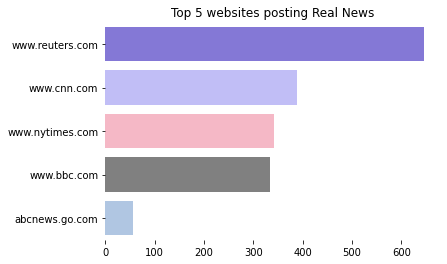

In [23]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

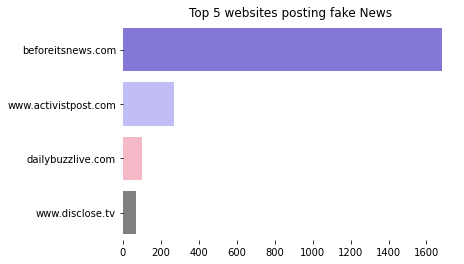

In [24]:
sns.barplot(y=fake_news_count[:5].index, x=fake_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting fake News');

**check if the dataset is balanced**

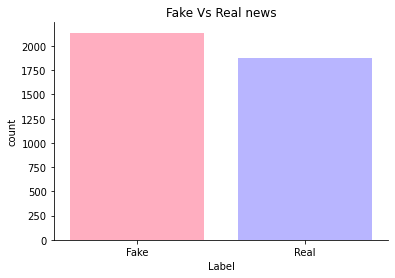

In [25]:
# making a bar plot to count the frequency of 
# fake and real news
sns.countplot(x='Label', 
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Fake Vs Real news');

In the dataset, there is no huge difference between the number of fake news as compare to real news so the dataset is balanced.

We can start working on it.

# 2. use the Text to make predictions

In [26]:
df.drop('Website', axis=1, inplace=True)
df.head()

,Label,text
0,1,Four ways Bob Corker skewered Donald Trump Ima...
1,1,Linklater's war veteran comedy speaks to moder...
2,1,Trump’s Fight With Corker Jeopardizes His Legi...
3,1,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,1,Jason Aldean opens 'SNL' with Vegas tribute Co...


# **Data Preprocessing**


In [47]:
#df.iloc[0,1]

I removed the unwanted words such as puntuation marks and stop words like - the, is, there, his etc. beacause these words are 
more frequent and don't have much importance. So, by removing these words we will get important words which will help us to find patterns regarding fake and real news.

Steps for text cleaning :
convert each word to lower case
remove URl links
remove stop words
remove any words apart from alphabets


In [28]:
stop_words = set(stopwords.words('english'))
to_remove = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.update(to_remove)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URL links 
    text = re.sub('\[[^]]*\]', '', text)
    text = (" ").join([word for word in text.split() if not word in stop_words])
    text = "".join([char for char in text if not char in to_remove])
    return text

df['text'] = df['text'].apply(clean_text)


In [48]:
#df.iloc[0,1]

In [30]:
df

,Label,text
0,1,four ways bob corker skewered donald trump ima...
1,1,linklaters war veteran comedy speaks modern am...
2,1,trump’s fight corker jeopardizes legislative a...
3,1,egypts cheiron wins tieup pemex mexican onshor...
4,1,jason aldean opens snl vegas tribute country s...
...,...,...
4003,0,cnn globalist exposed steve quayle alex jones ...
4004,0,trends watch trends watch readers think story ...
4005,0,trump jr soon give minute speech trump jr soo...
4007,1,china accept overseas trial data bid speed dru...


In [31]:
#from nltk.stem import WordNetLemmatizer
#lm = WordNetLemmatizer()
#def lemmatize_text(column):
 #   corpus = []
  #  for value in column:
   #     value = value.split()
    #    value = [lm.lemmatize(word) for word in column]
     #   corpus.append(' '.join(value))
    #return corpus    
#df['Text'] = lemmatize_text(df.text)

After cleaning ,i will try to extract the most frequent words in both real and fake news. To get this done, we can use a **cloud of words** which shows words frequency on the basis of their size which means words with bigger fontsize appear mostly as compare to other.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


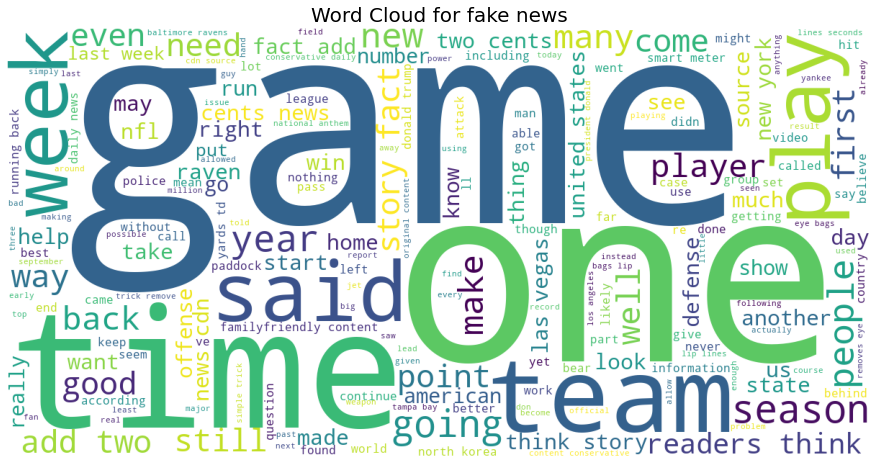

In [32]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

fake_news = df[data.Label == 0]
real_news = df[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(fake_news.text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(fake_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for fake news', fontsize=20);

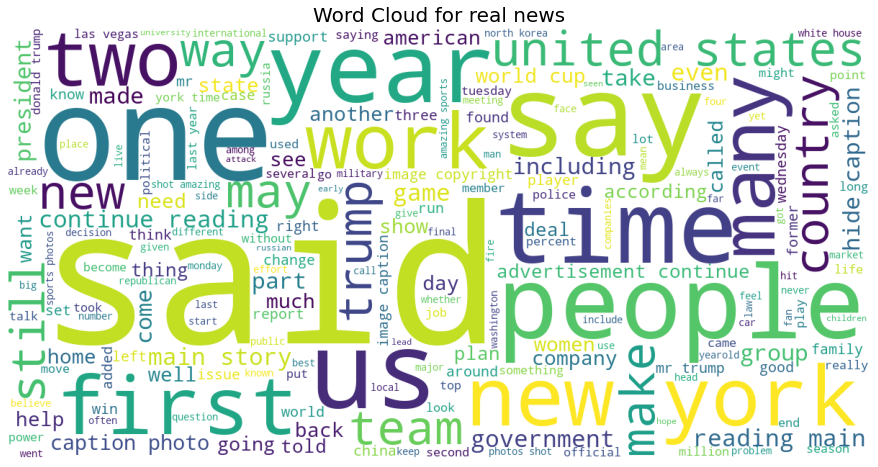

In [33]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(real_news.text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(real_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for real news', fontsize=20);

## **Modeling**

In [34]:
text_train, text_test, y_train, y_test = train_test_split(df['text'], df['Label'], test_size = 0.2, random_state = 42) 

In [35]:
size_embedding = 200 #Dimensionality of the feature vectors
windows = 3 #Maximum distance between the current and predicted word within a sentence
min_count = 1 #Ignores words with total frequency lower than this
maxlen = 1000 #Length decided for the text (adjusted by padding and truncating)

text_train_splited = [article.split() for article in text_train]
w2v_model = gensim.models.Word2Vec(sentences = text_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_splited)
text_train_tok = tokenizer.texts_to_sequences(text_train_splited)
word_index = tokenizer.word_index
print('Sive of vocabulary: ', len(word_index))

text_train_tok_pad = pad_sequences(text_train_tok, maxlen=maxlen)

Sive of vocabulary:  48852


In [37]:
def w2v_to_keras_weights(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, size_embedding))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

embedding_vectors = w2v_to_keras_weights(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [38]:
def set_model(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=maxlen, 
                        trainable=False))
    model.add(LSTM(units=32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model
model = set_model(embedding_vectors = embedding_vectors)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 200)         9770600   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 9,800,457
Trainable params: 29,857
Non-trainable params: 9,770,600
_________________________________________________________________


In [39]:
history = model.fit(text_train_tok_pad, y_train, validation_split=0.2, epochs=30, batch_size = 32, verbose = 1)

Epoch 1/30
80/80 [==============================] - 55s 439ms/step - loss: 0.4621 - acc: 0.7525 - val_loss: 0.2110 - val_acc: 0.9169
Epoch 2/30
80/80 [==============================] - 34s 421ms/step - loss: 0.2089 - acc: 0.9240 - val_loss: 0.1849 - val_acc: 0.9342
Epoch 3/30
80/80 [==============================] - 34s 422ms/step - loss: 0.1808 - acc: 0.9267 - val_loss: 0.1415 - val_acc: 0.9577
Epoch 4/30
80/80 [==============================] - 34s 428ms/step - loss: 0.1455 - acc: 0.9434 - val_loss: 0.1428 - val_acc: 0.9561
Epoch 5/30
80/80 [==============================] - 34s 420ms/step - loss: 0.1136 - acc: 0.9626 - val_loss: 0.1412 - val_acc: 0.9592
Epoch 6/30
80/80 [==============================] - 33s 417ms/step - loss: 0.1057 - acc: 0.9572 - val_loss: 0.1404 - val_acc: 0.9514
Epoch 7/30
80/80 [==============================] - 34s 420ms/step - loss: 0.0813 - acc: 0.9728 - val_loss: 0.1357 - val_acc: 0.9577
Epoch 8/30
80/80 [==============================] - 33s 416ms/step - 

In [40]:
model.fit(text_train_tok_pad, y_train, epochs=15, batch_size = 16, verbose = 0)


              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98       450
    Not Fake       0.98      0.98      0.98       348

    accuracy                           0.98       798
   macro avg       0.98      0.98      0.98       798
weighted avg       0.98      0.98      0.98       798



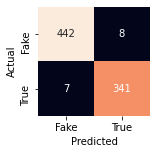

In [41]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

text_train_splited = [article.split() for article in text_test]
text_test_tok = tokenizer.texts_to_sequences(text_train_splited)
text_test_tok_pad = pad_sequences(text_test_tok, maxlen=maxlen)
pred = (model.predict(text_test_tok_pad) > 0.5).astype("int32")

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()

In [42]:
accuracy_score(y_test, pred)

0.981203007518797